In [1]:
# Importing libraries
import json
import pandas as pd
from pprint import pprint
import pandas_datareader.data as pdr
import datetime as dt
import numpy as np
import plotly.offline as py
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# DataFrame

In [2]:
###################################################################

    #Developing a class Dataframe to build a PandasDataframe 
    #around the scraped data regarding the stocks passed as 
    #input from the user.The script uses yahoo as the source of 
    #information.The information once scraped from yahoo is 
    #then turned into a DF which is further utilised for 
    #training,analysis and testing purposes.

        #Class has following attributes :
                #stock_name : Name of stock asset
                #start_date  : Initial date of record
                #end_date    : Last date of record
        
        #Class has following functionalities:
                #construct_df : returns the constructed DF
            
####################################################################

class Dataframe:
    # Class Initialisation
    def __init__(self,stock_name,start_date,end_date):
        self.stock_name=stock_name # Initialising the attributes
        self.start_date=start_date
        self.end_date=end_date
    
    
    # Class function
    def contruct_df(self):
        df = pdr.DataReader(self.stock_name,'yahoo',start,end)
        return df

# Graphs

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plot
import plotly.express as px

###########################################################################################
    #Developing a class plots to be used to plot various Graphs based on the 
    #DF which will be useful for analysing the underlying asset and predict what 
    #its future might hold.This class produces graphs for sole purpose of analysis.

    #Class has following attributes :
        #df : Dataframe being used for drawing graphs.
        
    #Class has following functionalities:
    
        #candle_stick    : Produces a candle stick graph
        
        #volume_chart    : Produces a line chart showing volume of the underlying asset.
                          
        #sma             : Produces SMA chart for 20,50
        
        #bollinger_bands : Produces the Bollinger Bands graph of the asset

###########################################################################################

class plots:
    def __init__(self,df): # Class Initialisation
        self.df=df
        
    def candle_stick(self):
        py.init_notebook_mode(connected=True) # To ensure to see the graph here
        
        #Preparing data for graph #
        data = [go.Candlestick(x=self.df.index,
                               open=self.df.Open,
                               high=self.df.High,
                               low=self.df.Low,
                               close=self.df.Close)]

        
        # Fixing the layout
        layout = go.Layout(title=f'{stock_name.upper()} Candlestick with Range Slider',
                           xaxis={'rangeslider':{'visible':True}})
        
        
        # Plotting the figure
        fig = go.Figure(data=data,layout=layout)
        fig.update_layout(
        title = f'The Candlestick graph for {stock_name}',
        xaxis_title = 'Date',
        yaxis_title = 'Price',
        xaxis_rangeslider_visible = True)
        fig.update_yaxes(tickprefix='$')
        py.iplot(fig,filename='f{stock_name.upper()}_candlestick')
        xaxis = {'rangeselector':{'buttons':[{'count':1,
                                      'label':'1m',
                                      'step':'month',
                                      'stepmode':'backward'}]}}
        
    def volume_chart(self):
        fig = px.line(df,y="Volume", title=f'Trade Volume of {stock_name.upper()}')
        fig.show()
    
    def sma(self):
        py.init_notebook_mode(connected=True)
        fig = go.Figure(
        data = [
            go.Candlestick(x=self.df.index,
                               open=self.df.Open,
                               high=self.df.High,
                               low=self.df.Low,
                               close=self.df.Close),
            go.Scatter(
                x = self.df.index, 
                y = self.df.Close.rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = self.df.index, 
                y = self.df.Close.rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            )
        ])
        # Setting up the titles on X,Y and Main
        xn='Date'
        fig.update_layout(
        title = f'The SMA graph for {stock_name}',
        xaxis_title = xn,
        yaxis_title = 'Price',
        xaxis_rangeslider_visible = True)
        fig.update_yaxes(tickprefix='$')

        fig.show()
    
    def bollinger_bands(self):
        self.df['MA20'] = self.df.Close.rolling(window=20).mean() # Preparing Mean of Close column in DF
        self.df['20dSTD'] = self.df.Close.rolling(window=20).std() # Preparing Standard deviationg of Close column in DF

        self.df['Upper'] = self.df['MA20'] + (self.df['20dSTD'] * 2) # Calculating upper Bollinger Band
        self.df['Lower'] = self.df['MA20'] - (self.df['20dSTD'] * 2) # Calculating lower Bolling Band
        self.df[['Close','MA20','Upper','Lower']].plot(figsize=(10,4)) # Plotting only the calculated Columns
        
        # Setting up the graph
        plot.title(stock_name + ' Bollinger Bands')
        plot.grid(True)
        plot.axis('tight')
        plot.ylabel('Price')
        plot.show()

# ARIMA-ML Model For Price Prediction

In [ ]:
# Importing important Libraries
import numpy as np
import pandas as pd 
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error  

########################### Model Details ###############################

    #The AutoRegressive Integrated Moving Average (ARIMA) is used here 
    #for time series price forecasting. The model takes historical 
    #data and forecasts the open price of the future.#The forecast is 
    #set for the next trading day, a longer forecast would reduce 
    #the accuracy of the model
    
    #Train:Test Split ratio : 80:20
    
    #A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model,
    #where: p is the number of autoregressive terms, d is the number of 
    #nonseasonal differences needed for stationarity, and q is the number 
    #of lagged forecast errors in the prediction equation.
    
    #The models : 
                 #p : 5
                 #d : 1
                 #q : 0
    
    #Why using ARIMA ?
    
    #ARIMA is much faster than for example LSTM and accuracy is much 
    #higher and doesnt need a static data for building and training.

###########################################################################

def AI(stock_name,df):
    
    #Splitting the DF into train and test
    train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    
    
    # Function for data reshaping
    def smape_kun(y_true, y_pred):
        return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
    
    #This function is typically used to format the data into correct form for the Model
    def inverse_difference(history, yhat, interval=1):
        return yhat + history[-interval]
    
    
    train_ar = train_data['Open'].values # Creating Train Array
    test_ar = test_data['Open'].values # Creating Test Array
    history = [x for x in train_ar] # Historical Close prices
    predictions = list() # Initialising the Predictions list
    
    
    # Processing each of the test data 
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast() # Forecasting the future
        yhat = output[0] # Yielding the correct data
        predictions.append(yhat) # Appending to the predictions
        obs = test_ar[t]
        history.append(obs)
    
    # Plotting the predictions and actual data for expressing Model Accuracy
    plt.figure(figsize=(12,7))
    plt.plot(df['Open'], 'green', color='blue', label='Training Data')
    plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
             label='Price Forecast')
    plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
    plt.title(f'{stock_name} Price Forecast')
    plt.xlabel('Dates')
    plt.ylabel('Close')
    try:
        plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
    except:
        pass
    plt.legend()
    plt.show()
    print(f'Price forecast next trading day : ${round(predictions[-1][0],2)}')
    print(f'AWARE! THIS IS NOT A STOCK RECOMMENDATION OR FINANCIAL ADVISE PLEASE TAKE FINANCIAL DECISION APPROPRIATELY')

# User Interface

Welcome to H$G-Elite-Trading
Enter a stock you would like to analyze : TSLA
Analysis for TSLA
From : 2010/01/01 To : 2021-05-29
 
Please select a option
1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Show Price forecast next trading day
6.Exit
Your Input : 5
Calculating price, please wait.....


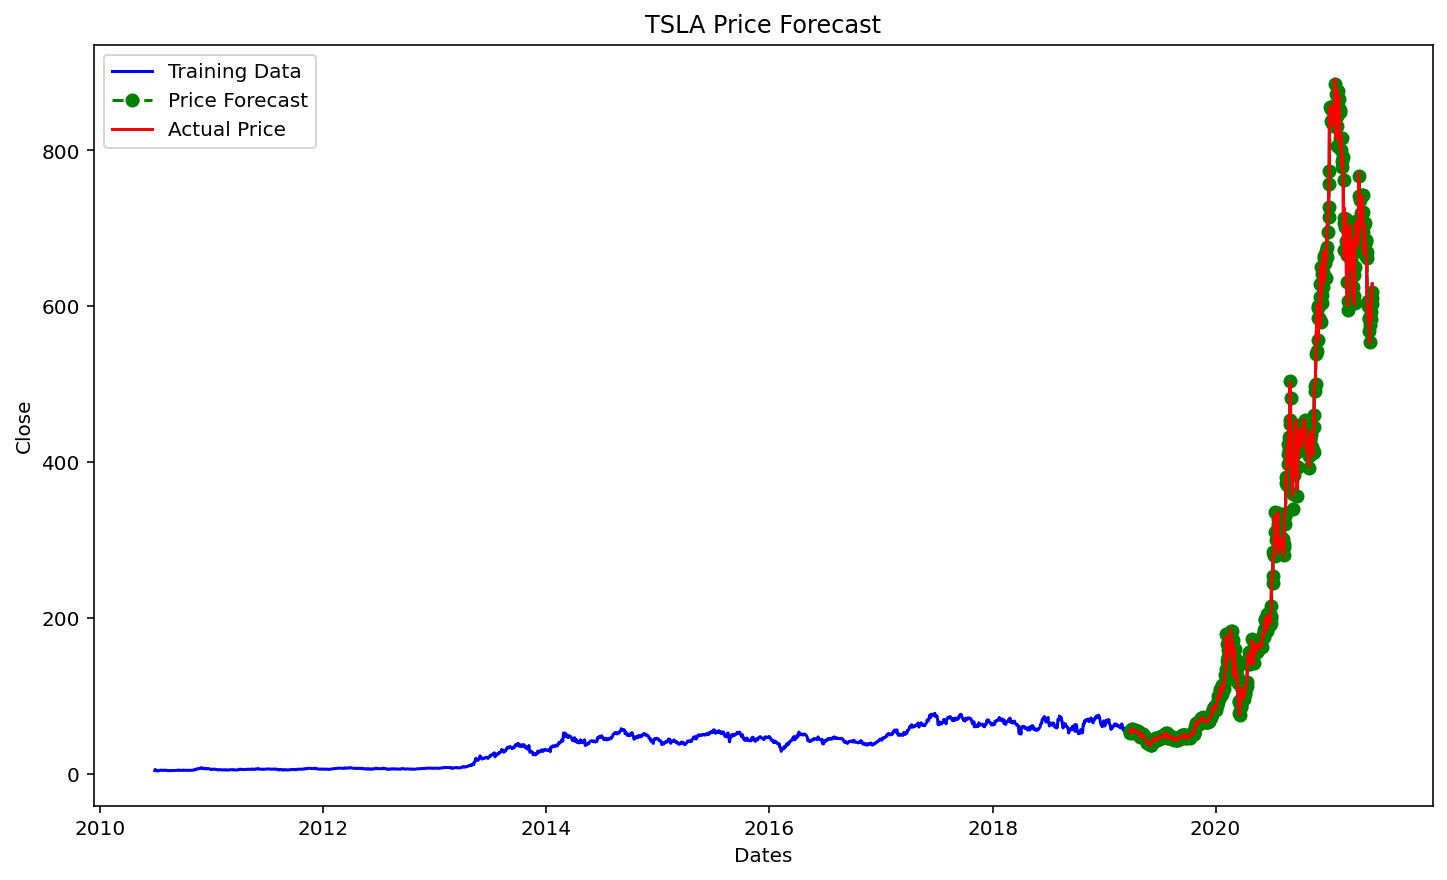

Price forecast next trading day : $618.21
AWARE! THIS IS NOT A STOCK RECOMMENDATION OR FINANCIAL ADVISE PLEASE TAKE FINANCIAL DECISION APPROPRIATELY


In [ ]:
################################ User Input #####################################################

stock_name=str(input('Welcome to H$G-Elite-Trading\nEnter a stock you would like to analyze : ')) 
start = '2010/01/01'
end = dt.date.today()
print(f'Analysis for {stock_name.upper()}\nFrom : {start} To : {end}\n ')

#################################################################################################

#Passing input variables into Dataframe Class
dfr=Dataframe(stock_name,start,end) # Creating Class object
df=dfr.contruct_df() # Calling Class function

plt_gr=plots(df)
print('Please select a option')
while True:
    x=int(input('1.Show Candlestick\n2.Show Volume Traded\n3.Show SMA20 and SMA50\n4.Show Bollinger Bands\n5.Show Price forecast next trading day\n6.Exit\nYour Input : '))
    if x==1:
        print('Use the Range Slider to analyze a specific period')
        plt_gr.candle_stick()
    elif x==2:
        plt_gr.volume_chart()
    elif x==3:
        print('Use the Range Slider to analyze a specific period')
        plt_gr.sma()
    elif x==4:
        plt_gr.bollinger_bands()
    elif x==5:
        print('Calculating price, please wait.....')
        AI(stock_name,df)
    elif x==6:
        print('Thank you and Goodbye :-)')
        break
    else:
        print('Invalid Input')